# неделя 01 + 02

# Coursera
## Анализ данных: финальный проект
### Жёлтое такси в Нью-Йорке

## исходные данные:
* страница со ссылками: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
* отдельные файлы:
    * за период с 2009-01 до 2019-06
        * https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2009-01.csv
        * ...
        * https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-06.csv
    
    * за период с 2019-07 до 2020-12
        * https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2019-07.csv
        * ...
        * https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2020-12.csv
    

In [1]:
# !pip install pandas
# !pip install fsspec
# !pip install matplotlib
# !pip install scipy
# !pip install basemap
# !pip install folium

In [2]:
import pandas as pd
from scipy import stats

from mpl_toolkits.basemap import Basemap

import folium
from folium.plugins import HeatMap

import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# вспомогательные функции
собраны в начало ноутбука, чтобы было удобнее перезапускать по частям

In [3]:
__nrows_full = None
__nrows_10 = 10_000

__nrows_week_01 = __nrows_full
# __nrows_week_01 = __nrows_10

__nrows_pipeline = __nrows_full
# __nrows_pipeline = __nrows_10

__need_save=True
# __need_save=False

__need_load=True
# __need_load=False


In [4]:
__resolution='f'
# __resolution='l'


In [5]:
new_york_coords = {
    'west': -74.25559, 
    'east': -73.70001, 
    'north': 40.91553, 
    'south': 40.49612, 
}


In [6]:
empire_state_building_coords = {
    'longitude': -73.9857,
    'latitude': 40.7484,
}
# 1231;-73.9889116;-73.9778;40.747766;40.7561542

In [7]:
statue_of_liberty_coords = {
    'longitude': -74.0445,
    'latitude': 40.6892,
}


In [8]:
# получаем список имен файлов по списку годов/месяцев

s3_amazonaws_com_nyc_tlc_link = 'https://s3.amazonaws.com/nyc-tlc/trip+data/'
nyc_tlc_s3_amazonaws_com_link = 'https://nyc-tlc.s3.amazonaws.com/trip+data/'
local_folder = '../data/'

def get_names(use_local, dates):
    result = []
    for year, month in dates:
        if use_local:
            result.append(f'{local_folder}yellow_tripdata_{year}-{month:02}.csv')
        else:
            result.append(f'{nyc_tlc_s3_amazonaws_com_link}yellow_tripdata_{year}-{month:02}.csv')
    
    return result
        

In [9]:
# загружаем весь список файлов в один длинный дата-фрейм

def load_data(names, nrows=None):
    result = None
    for name in names:
        load_df = pd.read_csv(f'{local_folder}yellow_tripdata_{2016}-{5:02}.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], nrows=nrows)
        if result is None:
            result = load_df
        else:
            result = pd.concat([
                result, 
                pd.read_csv(f'{local_folder}yellow_tripdata_{2016}-{5:02}.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], nrows=nrows)
            ])
    return result

In [10]:
# удаляем колонки, за исключением указанных

def drop_columns_except(data, columns):
    data.drop(columns=list(set(data.columns) - set(columns)), inplace=True)
    return data


In [11]:
# чистим данные

def clear_data(data):
    data.drop(data
              [
                (data['tpep_dropoff_datetime'] == data['tpep_pickup_datetime']) |    
                (data['passenger_count'] <= 0) |    
                (data['trip_distance'] <= 0) |    
                (data['pickup_longitude'] < new_york_coords['west']) | (data['pickup_longitude'] > new_york_coords['east']) |
                (data['pickup_latitude'] < new_york_coords['south']) | (data['pickup_latitude'] > new_york_coords['north'])
              ].index, inplace=True)
    
    return data


In [12]:
# округляем время до часов

def round_time(data):
    data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].dt.floor("H")
    return data

In [13]:
# считаем статистику по регионам

def calc_bins(data, bins):
    bins_result = stats.binned_statistic_2d(data['pickup_longitude'], data['pickup_latitude'], 
                                        None, 
                                        statistic='count', 
                                        bins=bins,
                                        expand_binnumbers=True,
                                       )
    data['region'] = (bins_result.binnumber[0] - 1) * 50 + bins_result.binnumber[1]
    
    return data

In [14]:
# считаем групповую статистику по регионам и часам

def calc_aggregated(data):
    result_aggregated = data.groupby(["tpep_pickup_datetime", "region"]).size().to_frame(name='count')
    
    return result_aggregated

In [15]:
# расширяем групповую статистику до полного набора всех возможных значений

def expand_aggregated(data_aggregated, datetime_all, region_all):
    all_product = pd.DataFrame([[x0, y0] for x0 in datetime_all for y0 in region_all], columns=['tpep_pickup_datetime', 'region'])
    all_product.set_index(['tpep_pickup_datetime', 'region'], inplace=True)
    all_product['count_dummy'] = None
    
    data_aggregated_all = all_product.join(data_aggregated)
    
    data_aggregated_all.drop(columns=['count_dummy'], inplace=True)
    
    data_aggregated_all.fillna(0, inplace=True)
    
    data_aggregated_all.reset_index(inplace=True)

    return data_aggregated_all

In [16]:
# полный цикл обработки для заданного списка файлов

def full_pipeline(names, nrows, bins, data_regions):
    result = load_data(names, nrows=nrows)
    result = drop_columns_except(result, ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'passenger_count', 'trip_distance'])

    result = clear_data(result)
    result = drop_columns_except(result, ['tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude'])
    
    result = round_time(result)
    
    result = calc_bins(result, bins=bins)
    result = drop_columns_except(result, ['tpep_pickup_datetime', 'region'])
    
    result_aggregated = calc_aggregated(result)
        
    result_aggregated_expanded = expand_aggregated(result_aggregated, result_aggregated.index.unique(level='tpep_pickup_datetime'), data_regions['region'].unique())
    result_aggregated_expanded = drop_columns_except(result_aggregated_expanded, ['tpep_pickup_datetime', 'region', 'count'])
    
    return result_aggregated_expanded


## списк ссылок для загрузки файлов

In [17]:
links_data_all = get_names(False, [(year, month) for year in range(2009, 2020 + 1) for month in range(1, 12 + 1)])

links_data_2_years = get_names(False, [(year, month) for year in range(2019, 2020 + 1) for month in range(1,  12 + 1)])

links_data_6_months = get_names(True, [(2020, month) for month in range(7, 12 + 1)])


In [18]:
links_data_6_months

['../data/yellow_tripdata_2020-07.csv',
 '../data/yellow_tripdata_2020-08.csv',
 '../data/yellow_tripdata_2020-09.csv',
 '../data/yellow_tripdata_2020-10.csv',
 '../data/yellow_tripdata_2020-11.csv',
 '../data/yellow_tripdata_2020-12.csv']

In [19]:
# links_data_2_years

In [20]:
# links_data_all

## регионы

In [21]:
data_regions = pd.read_csv(local_folder + 'regions.csv', sep=';')
data_regions

,region,west,east,south,north
0,1,-74.255590,-74.244478,40.496120,40.504508
1,2,-74.255590,-74.244478,40.504508,40.512896
2,3,-74.255590,-74.244478,40.512896,40.521285
3,4,-74.255590,-74.244478,40.521285,40.529673
4,5,-74.255590,-74.244478,40.529673,40.538061
...,...,...,...,...,...
2495,2496,-73.711122,-73.700010,40.873589,40.881977
2496,2497,-73.711122,-73.700010,40.881977,40.890365
2497,2498,-73.711122,-73.700010,40.890365,40.898754
2498,2499,-73.711122,-73.700010,40.898754,40.907142


In [22]:
# data_regions['west'].value_counts()
# data_regions['east'].value_counts()
# data_regions['south'].value_counts()
# data_regions['north'].value_counts()

In [23]:
# data_regions['west'].unique()
# data_regions['east'].unique()
# data_regions['south'].unique()
# data_regions['north'].unique()

In [24]:
len(data_regions['west'].unique()), len(data_regions['east'].unique()), len(data_regions['south'].unique()), len(data_regions['north'].unique())

(50, 50, 50, 50)

In [25]:
set(data_regions['west'].unique()) - set(data_regions['east'].unique())

{-74.25559}

In [26]:
set(data_regions['south'].unique()) - set(data_regions['north'].unique())

{40.49612}

In [27]:
x_bins = data_regions['west'].append(data_regions['east']).unique()
y_bins = data_regions['south'].append(data_regions['north']).unique()

len(x_bins), len(y_bins)

(51, 51)

# неделя 01

# Загрузите данные за май 2016 года.

In [28]:
data_2016_5 = load_data(get_names(True, [(2016, 5)]),
                        nrows=__nrows_week_01,
                       )
data_2016_5

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11836848,2,2016-05-27 12:24:58,2016-05-27 12:39:38,1,0.00,0.000000,0.000000,1,N,0.000000,0.000000,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
11836849,2,2016-05-27 12:44:54,2016-05-27 12:48:17,1,0.00,0.000000,0.000000,1,N,0.000000,0.000000,2,4.0,0.5,0.5,0.00,0.0,0.3,5.30
11836850,2,2016-05-27 12:48:51,2016-05-27 13:40:56,1,0.00,0.000000,0.000000,1,N,0.000000,0.000000,2,28.5,0.5,0.5,0.00,0.0,0.3,29.80
11836851,2,2016-05-27 14:18:21,2016-05-27 14:38:13,1,0.00,0.000000,0.000000,1,N,0.000000,0.000000,2,12.0,0.5,0.5,0.00,0.0,0.3,13.30


In [29]:
data_2016_5 = drop_columns_except(data_2016_5, ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'passenger_count', 'trip_distance'])
data_2016_5

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude
0,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040
1,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751
2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573
3,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601
4,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192
...,...,...,...,...,...,...
11836848,2016-05-27 12:24:58,2016-05-27 12:39:38,1,0.00,0.000000,0.000000
11836849,2016-05-27 12:44:54,2016-05-27 12:48:17,1,0.00,0.000000,0.000000
11836850,2016-05-27 12:48:51,2016-05-27 13:40:56,1,0.00,0.000000,0.000000
11836851,2016-05-27 14:18:21,2016-05-27 14:38:13,1,0.00,0.000000,0.000000


In [30]:
data_2016_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11836853 entries, 0 to 11836852
Data columns (total 6 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   passenger_count        int64         
 3   trip_distance          float64       
 4   pickup_longitude       float64       
 5   pickup_latitude        float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 541.8 MB


# Проведите фильтрацию: удалите поездки с
* нулевой длительностью
* нулевым количеством пассажиров
* нулевым расстоянием поездки по счётчику
* координатами начала, не попадающими в прямоугольник Нью-Йорка

In [31]:
data_2016_5 = clear_data(data_2016_5)
data_2016_5

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude
0,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040
1,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751
2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573
3,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601
4,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192
...,...,...,...,...,...,...
11836837,2016-05-31 23:53:01,2016-06-01 00:00:24,2,1.89,-73.947876,40.774818
11836838,2016-05-31 23:53:02,2016-06-01 00:19:36,1,15.21,-73.789467,40.646942
11836839,2016-05-31 23:53:02,2016-05-31 23:59:07,1,1.80,-74.008659,40.719723
11836840,2016-05-31 23:53:03,2016-06-01 00:05:47,1,2.28,-73.981644,40.758862


In [32]:
data_2016_5 = drop_columns_except(data_2016_5, ['tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude'])
data_2016_5

,tpep_pickup_datetime,pickup_longitude,pickup_latitude
0,2016-05-01 00:00:00,-73.985901,40.768040
1,2016-05-01 00:00:00,-73.991577,40.744751
2,2016-05-01 00:00:00,-73.993073,40.741573
3,2016-05-01 00:00:00,-73.991943,40.684601
4,2016-05-01 00:00:00,-74.005280,40.740192
...,...,...,...
11836837,2016-05-31 23:53:01,-73.947876,40.774818
11836838,2016-05-31 23:53:02,-73.789467,40.646942
11836839,2016-05-31 23:53:02,-74.008659,40.719723
11836840,2016-05-31 23:53:03,-73.981644,40.758862


# Отбросьте минуты и секунды во времени начала поездки.

In [33]:
data_2016_5 = round_time(data_2016_5)
data_2016_5

,tpep_pickup_datetime,pickup_longitude,pickup_latitude
0,2016-05-01 00:00:00,-73.985901,40.768040
1,2016-05-01 00:00:00,-73.991577,40.744751
2,2016-05-01 00:00:00,-73.993073,40.741573
3,2016-05-01 00:00:00,-73.991943,40.684601
4,2016-05-01 00:00:00,-74.005280,40.740192
...,...,...,...
11836837,2016-05-31 23:00:00,-73.947876,40.774818
11836838,2016-05-31 23:00:00,-73.789467,40.646942
11836839,2016-05-31 23:00:00,-74.008659,40.719723
11836840,2016-05-31 23:00:00,-73.981644,40.758862


# Агрегируйте данные за май 2016 года по часам и областям 

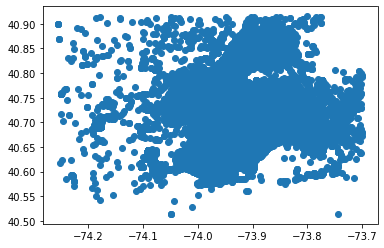

In [34]:
plt.plot(data_2016_5['pickup_longitude'], data_2016_5['pickup_latitude'], 'o')

## сопоставим визуально с картинкой
* <https://ru.wikipedia.org/wiki/%D0%91%D0%BE%D1%80%D0%BE_(%D0%9D%D1%8C%D1%8E-%D0%99%D0%BE%D1%80%D0%BA)>

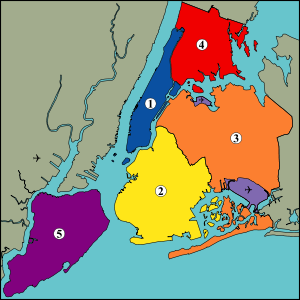


### Вывод:
* зрительно можно идентифицировать сгустки, который выглядят похоже на карту города
* а также видны явные выбросы

## попробуем просто разбить на бины 50*50

In [35]:
bins_result = stats.binned_statistic_2d(data_2016_5['pickup_longitude'], data_2016_5['pickup_latitude'], None, 'count', bins=50)
bins_result

BinnedStatistic2dResult(statistic=array([[0., 0., 0., ..., 0., 5., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), x_edge=array([-74.2551651 , -74.24406357, -74.23296204, -74.2218605 ,
       -74.21075897, -74.19965744, -74.18855591, -74.17745438,
       -74.16635284, -74.15525131, -74.14414978, -74.13304825,
       -74.12194672, -74.11084518, -74.09974365, -74.08864212,
       -74.07754059, -74.06643906, -74.05533752, -74.04423599,
       -74.03313446, -74.02203293, -74.0109314 , -73.99982986,
       -73.98872833, -73.9776268 , -73.96652527, -73.95542374,
       -73.9443222 , -73.93322067, -73.92211914, -73.91101761,
       -73.89991608, -73.88881454, -73.87771301, -73.86661148,
       -73.85550995, -73.84440842, -73.83330688, -73.82220535,
       -73.81110382, -73.80000229, -73.78890076, -73.77779922,
       -73.76669769, -73

In [36]:
bins_result.statistic.shape

(50, 50)

In [37]:
data_regions

,region,west,east,south,north
0,1,-74.255590,-74.244478,40.496120,40.504508
1,2,-74.255590,-74.244478,40.504508,40.512896
2,3,-74.255590,-74.244478,40.512896,40.521285
3,4,-74.255590,-74.244478,40.521285,40.529673
4,5,-74.255590,-74.244478,40.529673,40.538061
...,...,...,...,...,...
2495,2496,-73.711122,-73.700010,40.873589,40.881977
2496,2497,-73.711122,-73.700010,40.881977,40.890365
2497,2498,-73.711122,-73.700010,40.890365,40.898754
2498,2499,-73.711122,-73.700010,40.898754,40.907142


In [38]:
(data_regions['west'].min(), data_regions['west'].max()), \
(data_regions['east'].min(), data_regions['east'].max()), \
(data_regions['south'].min(), data_regions['south'].max()), \
(data_regions['north'].min(), data_regions['north'].max())


((-74.25559, -73.71112159999998),
 (-74.2444784, -73.70000999999999),
 (40.49612, 40.9071418),
 (40.504508200000004, 40.91553))

In [39]:
bins_result.x_edge.min(), bins_result.x_edge.max(), bins_result.y_edge.min(), bins_result.y_edge.max()

(-74.25516510009766, -73.70008850097656, 40.514068603515625, 40.91524887084961)

### Вывод:
* координаты регионов не совпадают

## возьмем координаты из файла регионов

In [40]:
x_bins

array([-74.25559  , -74.2444784, -74.2333668, -74.2222552, -74.2111436,
       -74.200032 , -74.1889204, -74.1778088, -74.1666972, -74.1555856,
       -74.144474 , -74.1333624, -74.1222508, -74.1111392, -74.1000276,
       -74.088916 , -74.0778044, -74.0666928, -74.0555812, -74.0444696,
       -74.033358 , -74.0222464, -74.0111348, -74.0000232, -73.9889116,
       -73.9778   , -73.9666884, -73.9555768, -73.9444652, -73.9333536,
       -73.922242 , -73.9111304, -73.9000188, -73.8889072, -73.8777956,
       -73.866684 , -73.8555724, -73.8444608, -73.8333492, -73.8222376,
       -73.811126 , -73.8000144, -73.7889028, -73.7777912, -73.7666796,
       -73.755568 , -73.7444564, -73.7333448, -73.7222332, -73.7111216,
       -73.70001  ])

In [41]:
y_bins

array([40.49612  , 40.5045082, 40.5128964, 40.5212846, 40.5296728,
       40.538061 , 40.5464492, 40.5548374, 40.5632256, 40.5716138,
       40.580002 , 40.5883902, 40.5967784, 40.6051666, 40.6135548,
       40.621943 , 40.6303312, 40.6387194, 40.6471076, 40.6554958,
       40.663884 , 40.6722722, 40.6806604, 40.6890486, 40.6974368,
       40.705825 , 40.7142132, 40.7226014, 40.7309896, 40.7393778,
       40.747766 , 40.7561542, 40.7645424, 40.7729306, 40.7813188,
       40.789707 , 40.7980952, 40.8064834, 40.8148716, 40.8232598,
       40.831648 , 40.8400362, 40.8484244, 40.8568126, 40.8652008,
       40.873589 , 40.8819772, 40.8903654, 40.8987536, 40.9071418,
       40.91553  ])

In [42]:
data_2016_5 = calc_bins(data_2016_5, [x_bins, y_bins])
data_2016_5


,tpep_pickup_datetime,pickup_longitude,pickup_latitude,region
0,2016-05-01 00:00:00,-73.985901,40.768040,1233
1,2016-05-01 00:00:00,-73.991577,40.744751,1180
2,2016-05-01 00:00:00,-73.993073,40.741573,1180
3,2016-05-01 00:00:00,-73.991943,40.684601,1173
4,2016-05-01 00:00:00,-74.005280,40.740192,1130
...,...,...,...,...
11836837,2016-05-31 23:00:00,-73.947876,40.774818,1384
11836838,2016-05-31 23:00:00,-73.789467,40.646942,2068
11836839,2016-05-31 23:00:00,-74.008659,40.719723,1127
11836840,2016-05-31 23:00:00,-73.981644,40.758862,1232


In [43]:
data_2016_5 = drop_columns_except(data_2016_5, ['tpep_pickup_datetime', 'region'])
data_2016_5

,tpep_pickup_datetime,region
0,2016-05-01 00:00:00,1233
1,2016-05-01 00:00:00,1180
2,2016-05-01 00:00:00,1180
3,2016-05-01 00:00:00,1173
4,2016-05-01 00:00:00,1130
...,...,...
11836837,2016-05-31 23:00:00,1384
11836838,2016-05-31 23:00:00,2068
11836839,2016-05-31 23:00:00,1127
11836840,2016-05-31 23:00:00,1232


In [44]:
data_aggregated = calc_aggregated(data_2016_5)
data_aggregated


count
tpep_pickup_datetime region       
2016-05-01 00:00:00  1015        1
                     1017        1
                     1029        3
                     1030        1
                     1033        4
...                            ...
2016-05-31 23:00:00  2069       17
                     2070        1
                     2118      192
                     2119       77
                     2168      132

[141762 rows x 1 columns]

In [45]:
len(data_aggregated.index.unique(level='region')), len(data_regions['region'].unique())

(1217, 2500)

In [46]:
len(data_aggregated.index.unique(level='tpep_pickup_datetime'))

744

In [47]:
len(data_aggregated), len(data_aggregated.index.unique(level='tpep_pickup_datetime')) * len(data_regions['region'].unique())

(141762, 1860000)

In [48]:
data_aggregated_expanded = expand_aggregated(data_aggregated, data_aggregated.index.unique(level='tpep_pickup_datetime'), data_regions['region'].unique())
data_aggregated_expanded

,tpep_pickup_datetime,region,count
0,2016-05-01 00:00:00,1,0.0
1,2016-05-01 00:00:00,2,0.0
2,2016-05-01 00:00:00,3,0.0
3,2016-05-01 00:00:00,4,0.0
4,2016-05-01 00:00:00,5,0.0
...,...,...,...
1859995,2016-05-31 23:00:00,2496,0.0
1859996,2016-05-31 23:00:00,2497,0.0
1859997,2016-05-31 23:00:00,2498,0.0
1859998,2016-05-31 23:00:00,2499,0.0


In [49]:
len(data_aggregated_expanded)

1860000

In [50]:
len(data_aggregated_expanded[data_aggregated_expanded['count'] != 0.0])

141762

In [51]:
len(data_aggregated_expanded[data_aggregated_expanded['count'] == 0.0])

1718238

# Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

In [52]:
data_aggregated_expanded

,tpep_pickup_datetime,region,count
0,2016-05-01 00:00:00,1,0.0
1,2016-05-01 00:00:00,2,0.0
2,2016-05-01 00:00:00,3,0.0
3,2016-05-01 00:00:00,4,0.0
4,2016-05-01 00:00:00,5,0.0
...,...,...,...
1859995,2016-05-31 23:00:00,2496,0.0
1859996,2016-05-31 23:00:00,2497,0.0
1859997,2016-05-31 23:00:00,2498,0.0
1859998,2016-05-31 23:00:00,2499,0.0


In [53]:
data_aggregated_expanded[data_aggregated_expanded['count'] != 0.0]

,tpep_pickup_datetime,region,count
1014,2016-05-01 00:00:00,1015,1.0
1016,2016-05-01 00:00:00,1017,1.0
1028,2016-05-01 00:00:00,1029,3.0
1029,2016-05-01 00:00:00,1030,1.0
1032,2016-05-01 00:00:00,1033,4.0
...,...,...,...
1859568,2016-05-31 23:00:00,2069,17.0
1859569,2016-05-31 23:00:00,2070,1.0
1859617,2016-05-31 23:00:00,2118,192.0
1859618,2016-05-31 23:00:00,2119,77.0


# Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

In [54]:
data_region_empire_state_building = data_regions[
    (data_regions['west'] <= empire_state_building_coords['longitude']) &
    (data_regions['east'] >= empire_state_building_coords['longitude']) &
    (data_regions['south'] <= empire_state_building_coords['latitude']) &
    (data_regions['north'] >= empire_state_building_coords['latitude'])            
]
       
data_region_empire_state_building

,region,west,east,south,north
1230,1231,-73.988912,-73.9778,40.747766,40.756154


In [55]:
region_empire_state_building = data_region_empire_state_building['region'][data_region_empire_state_building.index[0]]
region_empire_state_building

1231

In [56]:
data_count_empire_state_building = data_aggregated_expanded[data_aggregated_expanded['region'] == region_empire_state_building]
data_count_empire_state_building

,tpep_pickup_datetime,region,count
1230,2016-05-01 00:00:00,1231,881.0
3730,2016-05-01 01:00:00,1231,713.0
6230,2016-05-01 02:00:00,1231,533.0
8730,2016-05-01 03:00:00,1231,418.0
11230,2016-05-01 04:00:00,1231,353.0
...,...,...,...
1848730,2016-05-31 19:00:00,1231,1094.0
1851230,2016-05-31 20:00:00,1231,997.0
1853730,2016-05-31 21:00:00,1231,1099.0
1856230,2016-05-31 22:00:00,1231,874.0


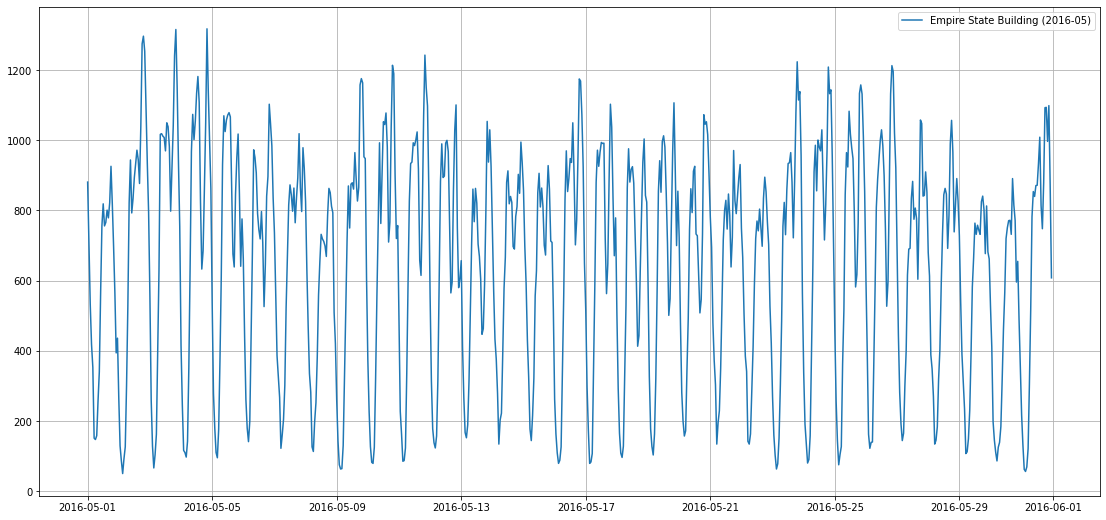

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(19, 9))
ax.plot(data_count_empire_state_building['tpep_pickup_datetime'], data_count_empire_state_building['count'], '-', label='Empire State Building (2016-05)')
ax.grid(True)
ax.legend()

# Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [58]:
len(data_aggregated_expanded[data_aggregated_expanded['count'] == 0])

1718238

# проверка полного цикла

In [59]:
result_2016_5 = full_pipeline(get_names(True, [(2016, 5)]),
                              nrows=__nrows_pipeline,
                              bins=[x_bins, y_bins],
                              data_regions=data_regions
                             )
result_2016_5

,tpep_pickup_datetime,region,count
0,2016-05-01 00:00:00,1,0.0
1,2016-05-01 00:00:00,2,0.0
2,2016-05-01 00:00:00,3,0.0
3,2016-05-01 00:00:00,4,0.0
4,2016-05-01 00:00:00,5,0.0
...,...,...,...
1859995,2016-05-31 23:00:00,2496,0.0
1859996,2016-05-31 23:00:00,2497,0.0
1859997,2016-05-31 23:00:00,2498,0.0
1859998,2016-05-31 23:00:00,2499,0.0


In [60]:
result_2016_5[result_2016_5['count'] != 0.0]

,tpep_pickup_datetime,region,count
1014,2016-05-01 00:00:00,1015,1.0
1016,2016-05-01 00:00:00,1017,1.0
1028,2016-05-01 00:00:00,1029,3.0
1029,2016-05-01 00:00:00,1030,1.0
1032,2016-05-01 00:00:00,1033,4.0
...,...,...,...
1859568,2016-05-31 23:00:00,2069,17.0
1859569,2016-05-31 23:00:00,2070,1.0
1859617,2016-05-31 23:00:00,2118,192.0
1859618,2016-05-31 23:00:00,2119,77.0


# сохраним результат в файл

In [61]:
if __need_save:
    result_2016_5.to_csv('result_2016_5.csv', index=False)

# неделя 02

## Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.

In [62]:
if __need_load:
    data_result = pd.read_csv('result_2016_5.csv', parse_dates=['tpep_pickup_datetime'])
else:
    data_result = result_2016_5
    
data_result

,tpep_pickup_datetime,region,count
0,2016-05-01 00:00:00,1,0.0
1,2016-05-01 00:00:00,2,0.0
2,2016-05-01 00:00:00,3,0.0
3,2016-05-01 00:00:00,4,0.0
4,2016-05-01 00:00:00,5,0.0
...,...,...,...
1859995,2016-05-31 23:00:00,2496,0.0
1859996,2016-05-31 23:00:00,2497,0.0
1859997,2016-05-31 23:00:00,2498,0.0
1859998,2016-05-31 23:00:00,2499,0.0


In [63]:
len(data_result[data_result['count'] == 0.0])

1718238

In [66]:
data_result[data_result['count'] > 0]

,tpep_pickup_datetime,region,count
1014,2016-05-01 00:00:00,1015,1.0
1016,2016-05-01 00:00:00,1017,1.0
1028,2016-05-01 00:00:00,1029,3.0
1029,2016-05-01 00:00:00,1030,1.0
1032,2016-05-01 00:00:00,1033,4.0
...,...,...,...
1859568,2016-05-31 23:00:00,2069,17.0
1859569,2016-05-31 23:00:00,2070,1.0
1859617,2016-05-31 23:00:00,2118,192.0
1859618,2016-05-31 23:00:00,2119,77.0


In [67]:
data_result['count'].sum()

11626521.0

In [68]:
data_sum = data_result.groupby(by=['region']).sum().reset_index()[['region', 'count']]
data_sum

,region,count
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0
...,...,...
2495,2496,0.0
2496,2497,0.0
2497,2498,0.0
2498,2499,0.0


In [69]:
data_sum['count'].sum()

11626521.0

In [70]:
data_sum[data_sum['count'] > 0]

,region,count
14,15,1.0
15,16,1.0
24,25,1.0
26,27,1.0
31,32,19.0
...,...,...
2482,2483,2.0
2483,2484,1.0
2484,2485,2.0
2485,2486,3.0


<AxesSubplot:>

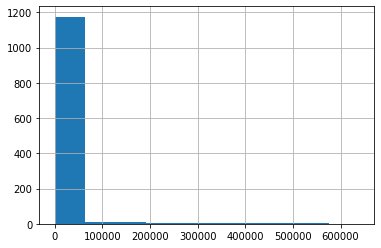

In [71]:
data_sum[data_sum['count'] > 0]['count'].hist()

In [86]:
len(data_sum[data_sum['count'] == 0])

1283

### Ответ:
1283

## Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг.

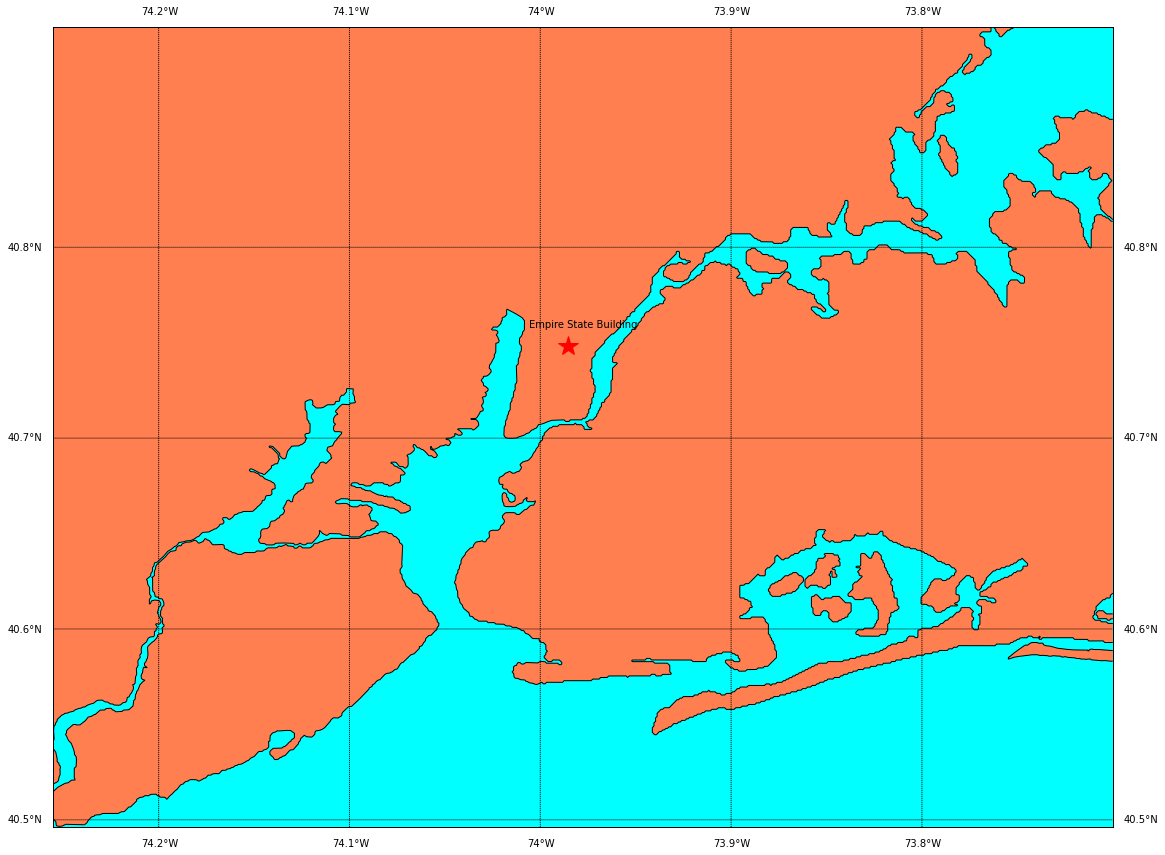

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(19, 19))

m = Basemap(
    llcrnrlon=new_york_coords['west'],
    llcrnrlat=new_york_coords['south'],
    urcrnrlon=new_york_coords['east'],
    urcrnrlat=new_york_coords['north'],
    resolution=__resolution,
    ax=ax,
)

m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='coral',lake_color='aqua')

parallels = np.arange(40.5, 40.9, .1)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,True,False,False])
meridians = np.arange(-74.2, -73.7, .1)
m.drawmeridians(meridians,labels=[False,False,True,True])

x, y = m(empire_state_building_coords['longitude'], empire_state_building_coords['latitude'])
m.plot(x, y, marker='*', color='r', markersize=20)
plt.annotate('Empire State Building', xy=(x-0.02, y+0.01))

plt.show()

## Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.

In [72]:
x_region = []
y_region = []
c_region = []

for n_region, count in data_sum.values:
    if count > 0:
        c_region.append(count)

        region_i = data_regions[data_regions['region'] == n_region]
        x_region.append((region_i['west'] + region_i['east']) / 2)
        y_region.append((region_i['south'] + region_i['north']) / 2)
    
x_region[:5], y_region[:5], c_region[:5]

([14   -74.250034
  dtype: float64,
  15   -74.250034
  dtype: float64,
  24   -74.250034
  dtype: float64,
  26   -74.250034
  dtype: float64,
  31   -74.250034
  dtype: float64],
 [14    40.617749
  dtype: float64,
  15    40.626137
  dtype: float64,
  24    40.701631
  dtype: float64,
  26    40.718407
  dtype: float64,
  31    40.760348
  dtype: float64],
 [1.0, 1.0, 1.0, 1.0, 19.0])

Text(-74.00569999999999, 40.758399999999995, 'Empire State Building')

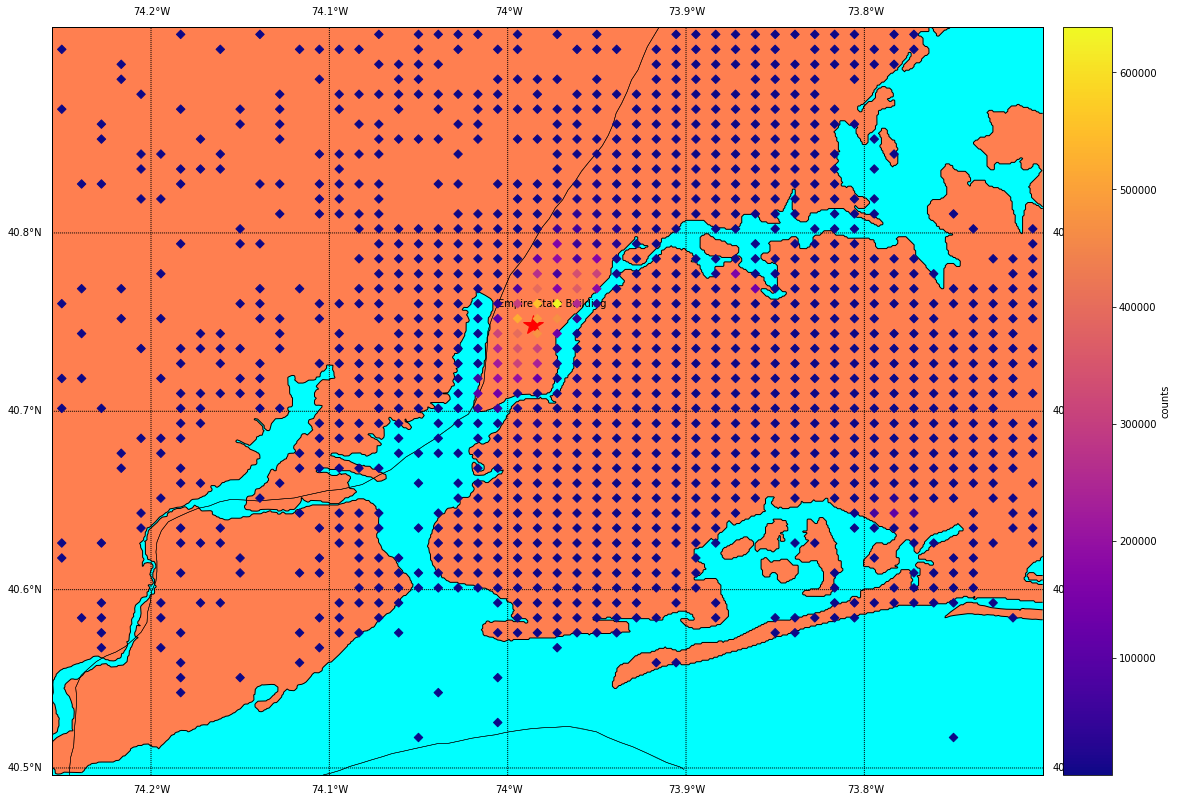

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(19, 19))

m = Basemap(
    llcrnrlon=new_york_coords['west'],
    llcrnrlat=new_york_coords['south'],
    urcrnrlon=new_york_coords['east'],
    urcrnrlat=new_york_coords['north'],
    resolution=__resolution,
    ax=ax,
)

m.drawcoastlines()
m.drawrivers()
m.drawstates()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='coral',lake_color='aqua')

x_map, y_map = m(x_region, y_region)
obj = m.scatter(x_map, y_map, marker='D',
                c=c_region,
                zorder=10,
                cmap='plasma',
               )

cb = m.colorbar(obj, ax=ax)
cb.set_label('counts')

parallels = np.arange(40.5, 40.9, .1)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,True,False,False])
meridians = np.arange(-74.2, -73.7, .1)
m.drawmeridians(meridians,labels=[False,False,True,True])

x, y = m(empire_state_building_coords['longitude'], empire_state_building_coords['latitude'])
m.plot(x, y, marker='*', color='r', markersize=20)
plt.annotate('Empire State Building', xy=(x-0.02, y+0.01))


# Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.

In [74]:
statue_of_liberty_coords

{'longitude': -74.0445, 'latitude': 40.6892}

In [75]:
m = folium.Map(location=[(new_york_coords['south'] + new_york_coords['north']) / 2, (new_york_coords['west'] + new_york_coords['east']) / 2], 
               zoom_start=11
              )

tooltip = "Statue of Liberty" 

folium.Marker(
    [statue_of_liberty_coords['latitude'], statue_of_liberty_coords['longitude']], popup="<i>Statue of Liberty</i>", tooltip=tooltip, icon=folium.Icon(color="green", icon="info-sign")
).add_to(m)

m

## Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

In [76]:
data_result

,tpep_pickup_datetime,region,count
0,2016-05-01 00:00:00,1,0.0
1,2016-05-01 00:00:00,2,0.0
2,2016-05-01 00:00:00,3,0.0
3,2016-05-01 00:00:00,4,0.0
4,2016-05-01 00:00:00,5,0.0
...,...,...,...
1859995,2016-05-31 23:00:00,2496,0.0
1859996,2016-05-31 23:00:00,2497,0.0
1859997,2016-05-31 23:00:00,2498,0.0
1859998,2016-05-31 23:00:00,2499,0.0


In [77]:
data_result['month'] = data_result['tpep_pickup_datetime'].dt.to_period('M')
data_result

,tpep_pickup_datetime,region,count,month
0,2016-05-01 00:00:00,1,0.0,2016-05
1,2016-05-01 00:00:00,2,0.0,2016-05
2,2016-05-01 00:00:00,3,0.0,2016-05
3,2016-05-01 00:00:00,4,0.0,2016-05
4,2016-05-01 00:00:00,5,0.0,2016-05
...,...,...,...,...
1859995,2016-05-31 23:00:00,2496,0.0,2016-05
1859996,2016-05-31 23:00:00,2497,0.0,2016-05
1859997,2016-05-31 23:00:00,2498,0.0,2016-05
1859998,2016-05-31 23:00:00,2499,0.0,2016-05


In [78]:
data_result[data_result['count'] > 0]

,tpep_pickup_datetime,region,count,month
1014,2016-05-01 00:00:00,1015,1.0,2016-05
1016,2016-05-01 00:00:00,1017,1.0,2016-05
1028,2016-05-01 00:00:00,1029,3.0,2016-05
1029,2016-05-01 00:00:00,1030,1.0,2016-05
1032,2016-05-01 00:00:00,1033,4.0,2016-05
...,...,...,...,...
1859568,2016-05-31 23:00:00,2069,17.0,2016-05
1859569,2016-05-31 23:00:00,2070,1.0,2016-05
1859617,2016-05-31 23:00:00,2118,192.0,2016-05
1859618,2016-05-31 23:00:00,2119,77.0,2016-05


In [79]:
len(data_result[data_result['count'] == 0.0])

1718238

In [80]:
data_mean = data_result.groupby(by=['region', 'month']).mean().reset_index()
data_mean

,region,month,count
0,1,2016-05,0.0
1,2,2016-05,0.0
2,3,2016-05,0.0
3,4,2016-05,0.0
4,5,2016-05,0.0
...,...,...,...
2495,2496,2016-05,0.0
2496,2497,2016-05,0.0
2497,2498,2016-05,0.0
2498,2499,2016-05,0.0


## Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.

In [81]:
data_mean[data_mean['count'] >= 5]

,region,month,count
1074,1075,2016-05,66.799731
1075,1076,2016-05,138.266129
1076,1077,2016-05,86.802419
1124,1125,2016-05,66.041667
1125,1126,2016-05,181.892473
...,...,...,...
2067,2068,2016-05,95.056452
2068,2069,2016-05,10.545699
2117,2118,2016-05,146.490591
2118,2119,2016-05,34.692204


In [82]:
data = []
polygon_regions_all = []

for n_region, month, count in data_mean.values:
    if count >= 5:
        c_region = count

        region_i = data_regions[data_regions['region'] == n_region]
        x_region = (region_i['west'] + region_i['east']) / 2
        y_region = (region_i['south'] + region_i['north']) / 2

        data.append([y_region.values[0], x_region.values[0], c_region])
        
        polygon_regions_all.append(
            [
                (region_i['north'].values[0], region_i['west'].values[0]), 
                (region_i['north'].values[0], region_i['east'].values[0]), 
                (region_i['south'].values[0], region_i['east'].values[0]), 
                (region_i['south'].values[0], region_i['west'].values[0]), 
                (region_i['north'].values[0], region_i['west'].values[0]), 
            ],
        )
        
data[:5]

[[40.7016309, -74.0166906, 66.7997311827957],
 [40.7100191, -74.0166906, 138.26612903225808],
 [40.718407299999996, -74.0166906, 86.8024193548387],
 [40.7016309, -74.005579, 66.04166666666667],
 [40.7100191, -74.005579, 181.89247311827958]]

In [83]:
len(data)

102

### Ответ:
* 102
* визуально невозможными выглядят 2 ячейки, находящиеся на взлетно-посадочных полосах аэропортов

In [84]:
m = folium.Map(location=[(new_york_coords['south'] + new_york_coords['north']) / 2, (new_york_coords['west'] + new_york_coords['east']) / 2], 
               zoom_start=11
              )

tooltip = "Statue of Liberty" 

folium.Marker(
    [statue_of_liberty_coords['latitude'], statue_of_liberty_coords['longitude']], popup="<i>Statue of Liberty</i>", tooltip=tooltip, icon=folium.Icon(color="green", icon="info-sign")
).add_to(m)

HeatMap(data).add_to(m)

for polygon_region in polygon_regions_all:
    folium.PolyLine(polygon_region, color='black', weight=0.2).add_to(m)

m
